In [1]:
import sys
import os

import torch
from torch import nn
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import numpy as np
from PIL import Image
from torchvision import models
import torch.optim as optim

import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms.functional import to_pil_image

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
from scipy.stats import entropy

from torchcam.methods import *
from torchcam.utils import overlay_mask

from flashtorch.saliency import Backprop
from flashtorch.activmax import GradientAscent
from flashtorch.utils import *

### Indice
1. Obtención del dataset
2. Analisis del dataset
3. Preprocesamiento del dataset
4. Creacion del modelo
5. Entrenamiento del modelo
6. Prediccion del modelo
7. Evaluacion del modelo
8. Conclusiones

#### 1. Obtención del dataset

Para la realizacion del Caso Kaggle, he decidido buscar un dataset similar al del https://www.kaggle.com/kvpratama/pokemon-images-dataset, ya que para lo que tenia en mente necesitaba la variante shiny de cada pokemon.
Para ello he utilizado la siguiente pagina https://pokemondb.net/pokedex/shiny y he extraido las imagenes de todos los pokemons.  
Para ello he preparado un script en javascript que busca las imagenes de todos los pokemons y coge la url de la imagen de shiny y el normal:

    function getUrls(class_name) {
        imgs_normal = document.getElementsByClassName(class_name);
        str = "";
        for (let i = 0; i < imgs_normal.length; i++) {
            if (imgs_normal[i].src != undefined) {
                str += imgs_normal[i].src + '\n';
            }
        }
        return str;
    }

    normal = getUrls('shinydex-sprite-normal');
    shini = getUrls('shinydex-sprite-shiny');

Con este obtenemos lo siguiente:    

![img](imgs/web1.png)

Como se puede apreciar en la imagen podemos ver todas las url de las imagenes de los pokemons.  
A continuacion utilizando la libreria `requests` he descargado las imagenes de los pokemons en formato png, el codigo es el siguiente:

    import requests

    FILE_NORMAL = 'links_normal.txt'
    FILE_SHINY = 'links_shiny.txt'

    DOWNLOADED_FOLDER = '../dataset/'

    def downloader(file_name):
        lines = open(file_name, 'r').read().split('\n')
        for line in lines:
            if line == '': continue
            url = line.split('/')
            name_img = DOWNLOADED_FOLDER + url[-2] + "/" + url[-1]
            print(f'Downloading {name_img}...')
            r = requests.get(line)
            open(f'{name_img}', 'wb').write(r.content)
            
    if __name__ == '__main__':
        downloader(FILE_NORMAL)
        downloader(FILE_SHINY)

De esta manera conseguimos descargar las imagenes de los pokemons y separarlas en dos carpetas, una para las imagenes normales y otra para las imagenes shiny.

**Antes de seguir con el caso Kaggle**, tuve problemas con el modelo que escogi (Pix2Pix, que es una GAN), el principal problema que he tenido ha sido el alto coste de entrenamiento de este modelo para el problema que queria afrontar. Por ese motivo He cambiado el proposito del Kaggle, el objetivo es ver si un modelo de red neuronal, mas sencillo que el anterior mencionado es capaz de distingir entre Pokemons y Digimons. El dataset de Digimon lo he consegido del siguiente repositorio git: https://github.com/DeathReaper0965/Digimon-Generator-GAN/blob/master/Digimon.zip 

#### 2. Analisis del dataset

En este apartado voy a analizar el dataset y ver las imagenes descargadas y su resolucion. Empizo creando funciones para la lectura, preprocesado y normalizacion.

In [53]:
def read_dataset_images(path, resize_size=(256, 256), add_white_bg=True):
    """
    Reads images from a directory and returns a list of images.
    """
    images = []
    for filename in os.listdir(path):
        png = Image.open(path + filename)
        png.load()
        # Cambiamos el formato de la imagen a RGB con el fondo a blanco
        if add_white_bg:
            background = Image.new("RGB", png.size, (255, 255, 255))
            background.paste(png, mask=png.split()[3])
            png = background
        # Redimensionamos la imagen
        png = png.resize(resize_size, Image.ANTIALIAS)
        images.append(np.array(png))
    return images

Tambien creo una funcion para mostar imagenes.

In [54]:
def show_images(images, n_rows_cols, labels):
    fig = plt.figure(figsize=(6, 6))
    grid = ImageGrid(   fig, 111,
                        nrows_ncols=(n_rows_cols, n_rows_cols),
                        axes_pad=0.4,
                    )
    for ax, im, lb in zip(grid, images, labels):
        ax.imshow(im)
        ax.title.set_text(f'Class {lb}')
    plt.show()

def show_eval(images, n_rows_cols, labels):
    fig = plt.figure(figsize=(6, 6))
    grid = ImageGrid(   fig, 111,
                        nrows_ncols=(n_rows_cols, n_rows_cols),
                        axes_pad=0.4,
                    )
    for ax, im, lb in zip(grid, images, labels):
        ax.imshow(im)
        ax.title.set_text('P = %.2f D = %.2f'% (lb[0], lb[1]))
    plt.show()

def load_img(path):
  png = Image.open(path)
  png = png.resize((128, 128), Image.ANTIALIAS)
  return np.array(png)

def test_one(img):
  test = load_img(img)
  a = prepara_test_img(test)
  result = model(a)
  result = torch.sigmoid(result).cpu().detach().numpy()[0]
  print(result)
  plt.imshow(test)

Esta funcion se encarga de descomprimir el dataset, para que en caso de trabajar en un entorno remoto poder subir el dataset.

In [ ]:
# Codigo para Colab
!unzip dataset.zip

Ahora procedo a cargar el dataset de Digimon y Pokemon. Nada mas leerlos, los pasamos a numpy y aplicamos un fondo de color blanco a aquellos que sean PNG (en mi claso el dataset de Pokemon es el que tiene el fondo transparente), con el ultimo parametro indicamos esto.

In [55]:
DATASET_URL_DIGIMON = 'dataset/Digimon/'
DATASET_URL_POKEMON = 'dataset/Pokemon/normal/'

pokemon = read_dataset_images(DATASET_URL_POKEMON, (128, 128), True)
digimon = read_dataset_images(DATASET_URL_DIGIMON, (128, 128), False)

Una vez cargados los dataset en la memoria, lo visualizamos.

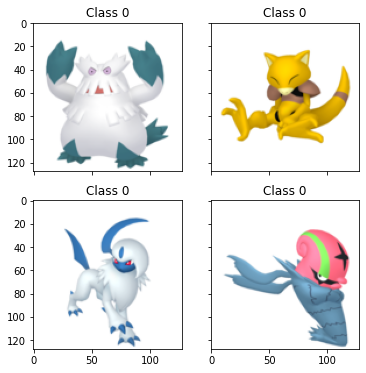

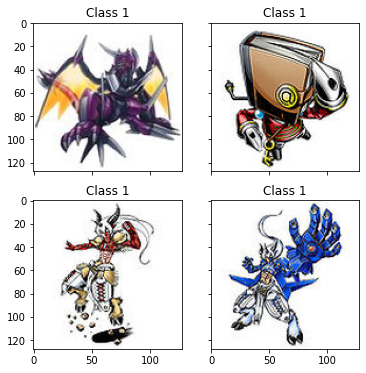

Dimension de la imagen (Pokemon):  (128, 128, 3)
Numero de imagenes (Pokemon):  895
Dimension de la imagen (Digimon):  (128, 128, 3)
Numero de imagenes (Digimon):  895


In [56]:
show_images(pokemon, 2, [0] * 4)
show_images(digimon, 2, [1] * 4)

print('Dimension de la imagen (Pokemon): ', pokemon[0].shape)
print('Numero de imagenes (Pokemon): ', len(pokemon))

print('Dimension de la imagen (Digimon): ', digimon[0].shape)
print('Numero de imagenes (Digimon): ', len(digimon))

Podemos observar que el dataset tiene la cantidad de 895 * 2 imagenes. Cada imagen tiene un tamaño de 128x128x3. En la parte superior de las imagenes tenemos los pokemons normales y en la parte inferior de las imagenes tenemos los digimons.

#### 3. Preprocesamiento del dataset

En esta apartado vamos realizar un preprocesamiento de las imagenes, como el dataset solo cuenta con 1790 imagenes y vamos a querer crear datos de train, validation y test, realizaremos un aumento de los datos y normalizacion. A continuacion vemos unas funciones para realizar este tratamiento:

In [57]:
def normalization(img):
  newX = []
  for i in img:
    newX.append(i/255)
  newX = np.stack(newX)
  newX = torch.Tensor(newX)
  return newX

def flip_image_vertical(inimg):
    '''
        Flipamos la imagen
    '''
    inimg = np.flip(inimg, 1)
    return inimg

def flip_image_horizontal(inimg):
    '''
        Flipamos la imagen
    '''
    inimg = np.flip(inimg, 0)
    return inimg

def to_tensor(X):
    new = []
    trans = transforms.ToTensor()
    for x in X: new.append(trans(x))
    return torch.Tensor(new)

def change_axis(X):
    new_X = []
    for x in X:
        new_X.append(np.transpose(x, (2, 0, 1)))
    return new_X

def data_augmentation(X, y):
    new_X = []
    new_y = []
    for i in range(len(X)-2):
        x_t = flip_image_vertical(X[i])
        new_X.append(x_t)
        new_y.append(y[i])

        x_t = flip_image_horizontal(X[i+1])
        new_X.append(x_t)
        new_y.append(y[i+1])

        x_t = flip_image_vertical(X[i+2])
        x_t = flip_image_horizontal(x_t)
        new_y.append(y[i+2])
        new_X.append(x_t)

    return new_X, new_y


Una vez que tenemos las funciones definidas vamos a aplicarlas sobre nuestro dataset, pero antes vamos a separa en datos de entremiento y test, ya que las imgenes de test no quiero que sean tratadas. De las 1790 imagenes el 75% seran para entrenamiento y validacion y el 25% de test.

In [58]:
# Agrupamos en el mismo datset las imagenes de pokemon y digimon

TRAIN_SIZE = 0.70

# Agrepamos en la misma lista las imagenes
X = pokemon + digimon

# Creamos las etiquetas
y = [0] * len(pokemon) + [1] * len(digimon)

# Agremaos las imagenes y las etiquetas
dataset = list(zip(X, y))

# Mezclamos
np.random.seed(42)
np.random.shuffle(dataset)

# Separamos el dataset en X e y (y Train y Test)
X_train, y_train = zip(*dataset[:int(TRAIN_SIZE * len(dataset))])
X_test, y_test = zip(*dataset[int(TRAIN_SIZE * len(dataset)):])

In [59]:
print('Imagenes train/validacion:', len(X_train))
print('Imagenes test:', len(X_test))

Imagenes train/validacion: 1253
Imagenes test: 537


Podemos ver que nos acaba quedando 1253 imagenes de train y 537 de test. Ahora pasaremos a aplicar la normalizacion y el data-aumentation a los datos de test.

In [60]:
# Aumentamos los datos con las siguiente tranformaciones:
# Volteado vertical
# Volteado horizontal
# Los dos
X_train, y_train = data_augmentation(X_train, y_train)

# Cambiamos el axis de cada imagen, pasamos de 128, 128, 3 --> 3, 128, 128
X_train = change_axis(X_train)

# Lo pasamos a numpy array
X_train = np.stack(X_train)

# Lo pasamos a un tensor de pytorch
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train).type(torch.LongTensor) # Long porque es categorico

X_train = normalization(X_train)

# Ahora lo pasamos a la clase Dataset propia de Pytorch
train_dataset = TensorDataset(X_train, y_train)
train_set_size = int(len(train_dataset) * 0.85)
valid_set_size = len(train_dataset) - train_set_size
train_set, valid_set = torch.utils.data.random_split(train_dataset, [train_set_size, valid_set_size])

train_set = DataLoader(train_set, batch_size=16, shuffle=True)
valid_set = DataLoader(valid_set, batch_size=16, shuffle=True)

A continuacion podemos ver como ha funcionado el data-aumentation. Ya que la imagen se encuntra volteda. Tambine esta aplicada la normalizacion.

tensor([0.6667, 0.3098, 0.4000])


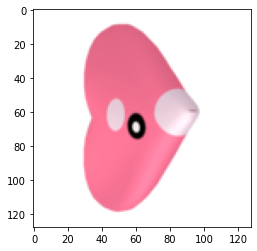

In [62]:
plt.imshow(X_train[5].permute(1, 2, 0).float())
print(X_train[5].permute(1, 2, 0)[65][65])

Finalmente nos queda las siguientes cantidades despues de aplicar data-aumentation:

In [63]:
print('Datos de entreamiento:', len(train_set)*train_set.batch_size)
print('Datos de validacion:', len(valid_set)*valid_set.batch_size)
print('Datos de test:', len(X_test))

Datos de entreamiento: 3200
Datos de validacion: 576
Datos de test: 537


#### 4. Entrenamiento del modelo

Ahora pasaremos a probar diferentes modelos a ver cual es el que mejor se ajusta a nuestro problema. Emepzaremos con el mas sencillo de los que se encuentra en los predefinidos por pytorch (son modelos populares, que dieron buenos resultados en diferentes competiciones), el primer modelo a probar sera Alexnet. El optimizador que he escogido ha sido Adam con un learning-rate del 0.000001 (que despues de unas pocas pruebas he visto que hace converger bien el modelo en 30 epocas).

En caso de tener el modelo entrenado no es necesario volver a entrenarlo, para ello lo cargamos de la carpeta models:

In [64]:
def alexnet():
    # Cargamos el modelo
    model = models.alexnet()
    # Modificamos la capa de salida para que solamente tenga 2 neuronas
    model.classifier[6] = nn.Linear(4096, 2)
    model.eval()
    # Mostramos el modelo
    print(model)
    return model

En caso de no querer entrenar el modelo, podemos cargarlo de la siguiente manera, este entrenamiento se ha realizado en la nube con las graficas de Google Colab.

In [68]:
checkpoint = torch.load('models/alexnet.pt')
model = alexnet()
model.cuda()
model.load_state_dict(checkpoint['model_state_dict'])
train_loss = checkpoint['train_loss']
validation_acc = checkpoint['validation_acc']

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

En caso de querer entrenar el modelo podemos utilizar la siguientes 3 celdas:

In [ ]:
train_on_gpu = torch.cuda.is_available()

model = alexnet()
# Creamos el optimizador y el criterio de error
optimizer = optim.Adam(model.parameters(), lr=0.000001)
criterion = nn.CrossEntropyLoss()

if train_on_gpu: model.cuda()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Crearemos funciones para entrenar y validar nuestro modelos, asi podemos ir viendo como se entrenando nuestro modelo.

In [66]:
def train(model, optimizer, criterion, train_set, info, train_loss):
      running_loss = 0.0
      for i, data in enumerate(train_set, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data[0].to(device), data[1].to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          output = model(inputs)
          loss = criterion(output, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          if i % info == 1 and i != 0:
            sys.stdout.write(f'\rEpoca {epoch + 1} Batch {i + 1} Train loss { running_loss / info }')
            train_loss.append(running_loss / info)
            running_loss = 0.0

def validate(model, criterion, valid_set, validation_acc):                       
    correct = 0                                               
    total = 0                                                 
    running_loss = 0.0                                        
    model.eval()                                              
    with torch.no_grad():                                     
        for i, data in enumerate(valid_set):                     
            inputs, labels = data                             
            inputs = inputs.to(device)                        
            labels = labels.to(device)                        
                                                              
            outputs = model(inputs)                           
            loss = criterion(outputs, labels)                 
            _, predicted = torch.max(outputs.data, 1)         
            total += labels.size(0)                           
            correct += (predicted == labels).sum().item()     
            running_loss = running_loss + loss.item()         
    mean_val_accuracy = (100 * correct / total)               
    mean_val_loss = ( running_loss )        
    print('\nValidation Accuracy: %d %%' % (mean_val_accuracy)) 
    print('Validation Loss:' , mean_val_loss )     
    validation_acc.append(mean_val_accuracy)

En la funcion de entrenamiento vamos a ir guardando cada 10 iteraciones, el loss del entrenamiento y mostraremos por pantalla el avance. En cambio la validacion solamente la haremos cada epoca. El numero de epocas es de 30.

In [ ]:
validation_acc = []
train_loss = []

for epoch in range(30):  # loop over the dataset multiple times
  train(model, optimizer, criterion, train_set, 10, train_loss)
  validate(model, criterion, valid_set, validation_acc)

print('Finished Training of AlexNet')

Epoca 1 Batch 192 Train loss 0.6864754557609558
Validation Accuracy: 45 %
Validation Loss: 24.61033570766449
Epoca 2 Batch 192 Train loss 0.5206470519304276
Validation Accuracy: 87 %
Validation Loss: 17.78410366177559
Epoca 3 Batch 192 Train loss 0.20303622260689735
Validation Accuracy: 90 %
Validation Loss: 8.378795735538006
Epoca 4 Batch 192 Train loss 0.23342594504356384
Validation Accuracy: 92 %
Validation Loss: 6.827998608350754
Epoca 5 Batch 192 Train loss 0.19033642411231994
Validation Accuracy: 92 %
Validation Loss: 7.302201382815838
Epoca 6 Batch 192 Train loss 0.16615437269210814
Validation Accuracy: 93 %
Validation Loss: 5.844204254448414
Epoca 7 Batch 192 Train loss 0.14269529320299626
Validation Accuracy: 93 %
Validation Loss: 5.590006528422236
Epoca 8 Batch 192 Train loss 0.17096865996718408
Validation Accuracy: 94 %
Validation Loss: 6.258397417142987
Epoca 9 Batch 192 Train loss 0.18824777826666833
Validation Accuracy: 94 %
Validation Loss: 6.2511510625481606
Epoca 10 Ba

Una vez entrenado, para almacenar el estado de entrenaminto y los pesos del modelos, utilizamos la funcion save de pytorch. La informacion que almacenamos es la siguiente:
- epoch: numero de epocas donde nos hemos quedado entrenando el modelo
- model_state_dict: estado del modelo
- optimizer_state_dict: estado del optimizador
- loss: loss del entrenamiento
- train_loss: lista de todos los losses del entrenamiento
- validacion_loss: lista de todos los losses de validacion 

In [ ]:
torch.save({
            'epoch': 30,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss[-1],
            'train_loss': train_loss,
            'validation_acc': validation_acc
            }, 'models/alexnet.pt')

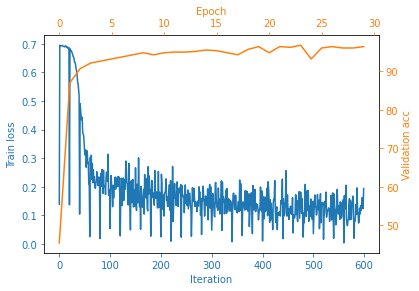

Last train loss: 0.19413039572536944 Last validation acc: 96.44760213143873


In [70]:
def plot_train_loss_acc(train_loss, validation_acc):
  fig=plt.figure()
  ax=fig.add_subplot(111, label="train")
  ax2=fig.add_subplot(111, label="validation", frame_on=False)

  ax.plot(train_loss, color="C0")
  ax2.plot(validation_acc, color="C1")

  ax.set_xlabel('Iteration', color="C0") 
  ax.set_ylabel('Train loss', color="C0")
  ax.tick_params(axis='x', colors="C0")
  ax.tick_params(axis='y', colors="C0")
  ax2.set_xlabel('Epoch', color="C1") 
  ax2.set_ylabel('Validation acc', color="C1")
  ax2.xaxis.tick_top()
  ax2.yaxis.tick_right()
  ax2.xaxis.set_label_position('top') 
  ax2.yaxis.set_label_position('right') 
  ax2.tick_params(axis='x', colors="C1")
  ax2.tick_params(axis='y', colors="C1")

  plt.show()

plot_train_loss_acc(train_loss, validation_acc)
print('Last train loss:',train_loss[-1], 'Last validation acc:', validation_acc[-1])

#### 5. Evaluacion del modelo

Para la evaluacion del modelo he preparado una funcion eval, que pasara por el modelo todos los datos de test que he guardado al principio. Y a ver que precide el modelo.

In [81]:
def prepara_test_img(img, cuda = False):
  X = img/255
  X = X.transpose((2, 0, 1)).astype('float32')
  if cuda:
    return torch.tensor([X], requires_grad=True).cuda()
  else:
    return torch.tensor([X], requires_grad=True)

def eval(X_test, y_test, model, cuda = False):
  bad_predictions = []
  good_predictions = []
  predictions = []
  for img, b in zip(X_test, y_test):
      a = prepara_test_img(img, cuda)
      result = model(a)
      result = torch.sigmoid(result).cpu().detach().numpy()[0]
      if result.argmax() != b:
        bad_predictions.append((img, result))
      else:
        good_predictions.append((img, result))
      predictions.append((b, result.argmax()))

  res = list(zip(*predictions))
  return {'predictions': res, 'good_predictions': good_predictions, 'bad_predictions': bad_predictions}

def show_acc(results):
  sn.heatmap(confusion_matrix(*results['predictions']), annot=True, fmt='g')
  plt.show()
  print(classification_report(*results['predictions']))

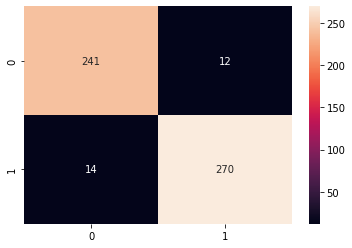

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       253
           1       0.96      0.95      0.95       284

    accuracy                           0.95       537
   macro avg       0.95      0.95      0.95       537
weighted avg       0.95      0.95      0.95       537



In [82]:
results = eval(X_test, y_test, model, True)
show_acc(results)

Podemos ver que tenemos una mejor precision cuando se trata de Digimons, esto es dado en parte porque tenemos mas imagenes de Digimons que de Pokemon para el test. Ahora vamos a visualizar de manera grafica las imagenes erroneas con peor tasa de fallo y las imagenes correctas con mas acierto. Esto es posible realizando la operacion sigmoid con el output de las 2 neuronas. Asi podemos ver que el lo que el clasificador considera "muy" Pokemon y lo que considera "muy" Digimon.

In [83]:
def eval_img(results):
  sorted_good_pokemon = sorted(results['good_predictions'], key= lambda x: x[1][0], reverse=True)
  sorted_good_digimon = sorted(results['good_predictions'], key= lambda x: x[1][1], reverse=True)

  sorted_bad_pokemon = sorted(results['bad_predictions'], key= lambda x: x[1][0], reverse=True)
  sorted_bad_digimon = sorted(results['bad_predictions'], key= lambda x: x[1][1], reverse=True)

  all_pred = sorted_good_pokemon + sorted_bad_pokemon
  all_pred = sorted(all_pred, key= lambda x: entropy(x[1]), reverse=True)

  demostration_img = [sorted_good_pokemon[0][0], sorted_good_digimon[0][0], sorted_bad_pokemon[0][0], sorted_bad_digimon[0][0]]
  demostration_lab = [sorted_good_pokemon[0][1], sorted_good_digimon[0][1], sorted_bad_pokemon[0][1], sorted_bad_digimon[0][1]]

  show_eval(demostration_img, 2, demostration_lab)
  show_eval([all_pred[0][0]], 1, [all_pred[0][1]])

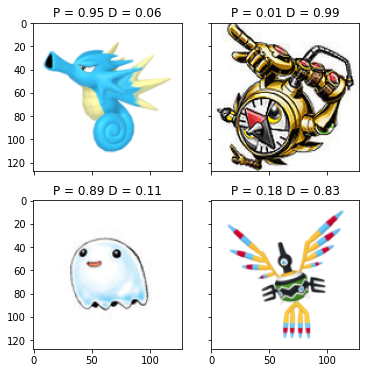

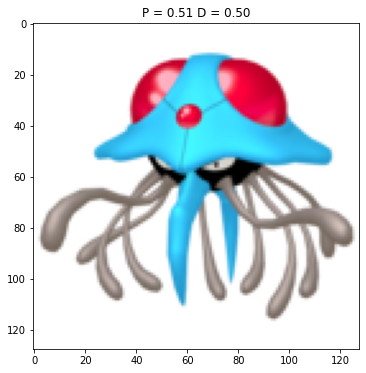

In [84]:
eval_img(results)

#### 6. Probado otros modelos
Ahora vamos a probar otro modelo mas potente, para ver como se comporta sobre el mismo dataset. El modelo escogido es vgg16. Este se compone con muchas mas capas convolucionales que Alexnex, por lo que preveo que es capaz de aprender mas patrones y texturas, esto puedo ayudar a generalizar mas el modelo.

In [95]:
def vgg():
    model = models.vgg16(init_weights=True)
    model.classifier[6]=nn.Linear(4096,2)
    return model

In [96]:
checkpoint = torch.load('models/vgg.pt')
model_vgg = vgg()
model_vgg.cuda()
model_vgg.load_state_dict(checkpoint['model_state_dict'])

RuntimeError: CUDA out of memory. Tried to allocate 392.00 MiB (GPU 0; 4.00 GiB total capacity; 2.65 GiB already allocated; 0 bytes free; 2.67 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
train_on_gpu = torch.cuda.is_available()
torch.cuda.empty_cache()
model_vgg = vgg()

validation_acc = []
train_loss = []

optimizer_inception = optim.Adam(model_vgg.parameters(), lr=0.000001)
criterion_inception = nn.CrossEntropyLoss()

if train_on_gpu: model_vgg.cuda()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for epoch in range(30):  # loop over the dataset multiple times
  train(model_vgg, optimizer_inception, criterion_inception, train_set, 10, train_loss)
  validate(model_vgg, criterion_inception, valid_set, validation_acc)

print('Finished Training of Inception')

Epoca 1 Batch 192 Train loss 0.6782909095287323
Validation Accuracy: 60 %
Validation Loss: 24.202041566371918
Epoca 2 Batch 192 Train loss 0.21379646509885789
Validation Accuracy: 94 %
Validation Loss: 7.544792488217354
Epoca 3 Batch 192 Train loss 0.13442380130290985
Validation Accuracy: 96 %
Validation Loss: 5.062833419069648
Epoca 4 Batch 192 Train loss 0.14674651809036732
Validation Accuracy: 97 %
Validation Loss: 3.646507401019335
Epoca 5 Batch 192 Train loss 0.11761846374720335
Validation Accuracy: 97 %
Validation Loss: 3.178565138950944
Epoca 6 Batch 192 Train loss 0.07367573631927371
Validation Accuracy: 98 %
Validation Loss: 2.7855377211235464
Epoca 7 Batch 192 Train loss 0.1128384506329894
Validation Accuracy: 97 %
Validation Loss: 2.8363937698304653
Epoca 8 Batch 192 Train loss 0.1162945058196783
Validation Accuracy: 98 %
Validation Loss: 2.350607785396278
Epoca 9 Batch 192 Train loss 0.09975606189109384
Validation Accuracy: 97 %
Validation Loss: 2.581496083177626
Epoca 10 B

Una vez entrenado el modelo almacenamos el estado actual. El tiempo de entreno ha sido de 29 minutos. Con un batch size de 16 y utlizando colab de Google.

In [ ]:
torch.save({
            'epoch': 30,
            'model_state_dict': model_vgg.state_dict(),
            'optimizer_state_dict': optimizer_inception.state_dict(),
            'loss': train_loss[-1],
            'train_loss': train_loss,
            'validation_acc': validation_acc
            }, 'models/vgg.pt')

In [ ]:
results = eval(X_test, y_test, model_vgg)

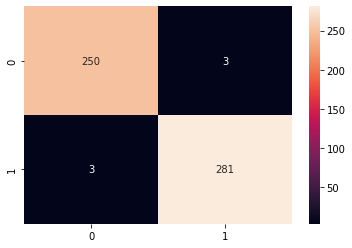

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       253
           1       0.99      0.99      0.99       284

    accuracy                           0.99       537
   macro avg       0.99      0.99      0.99       537
weighted avg       0.99      0.99      0.99       537



In [ ]:
show_acc(results)

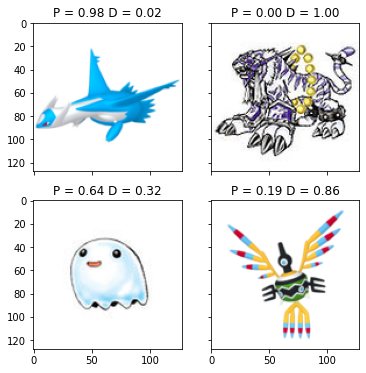

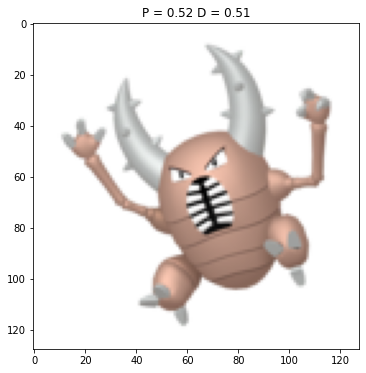

In [ ]:
eval_img(results)

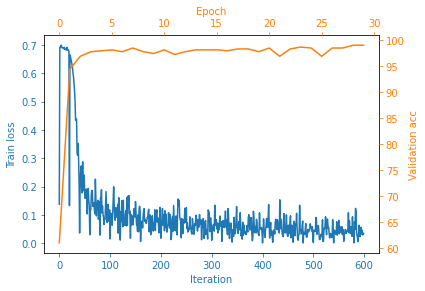

In [ ]:
plot_train_loss_acc(checkpoint['train_loss'], checkpoint['validation_acc'])

In [ ]:
print(model_vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

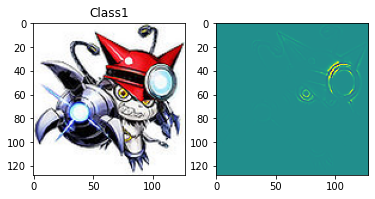

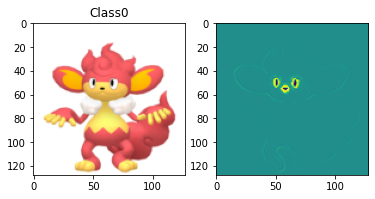

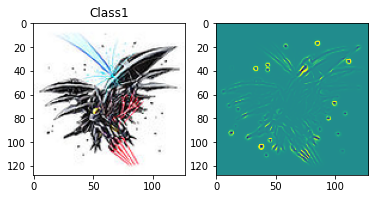

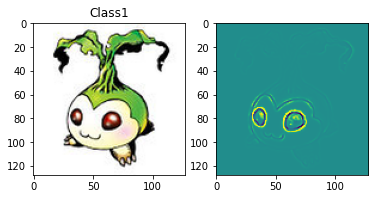

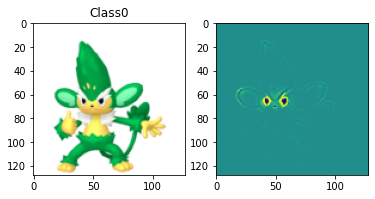

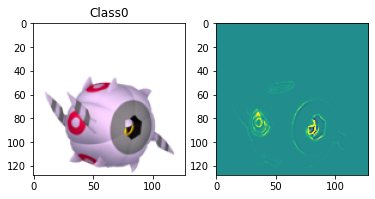

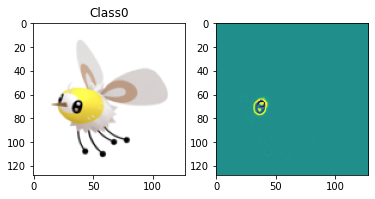

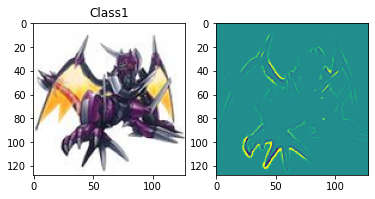

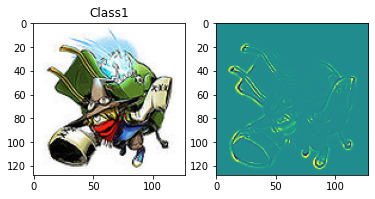

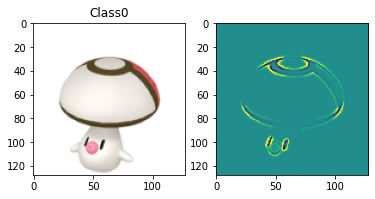

In [48]:

def show_max_gradients(X_test, y_test):
    asc = Backprop(model_vgg)
    for img, lab in zip(X_test, y_test):
        img2 = prepara_test_img(img)
        max_gradients = asc.calculate_gradients(img2, lab, take_max=True, guided = True)
        # Show two images with their respective gradients
        plt.subplot(1, 2, 1)
        plt.title('Class ' + str(lab))
        plt.imshow(img)
        plt.subplot(1, 2, 2)
        plt.imshow(format_for_plotting(standardize_and_clip(max_gradients)))
        plt.show()
        

show_max_gradients(X_test[:10], y_test[:10])

In [35]:
def vgg_pre():
    model = models.vgg16(pretrained=True)
    model.classifier[6]=nn.Linear(4096,2)
    return model

train_on_gpu = torch.cuda.is_available()
torch.cuda.empty_cache()
model_vgg = vgg_pre()

validation_acc = []
train_loss = []

optimizer_inception = optim.Adam(model_vgg.parameters(), lr=0.000001)
criterion_inception = nn.CrossEntropyLoss()

if train_on_gpu: model_vgg.cuda()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for epoch in range(11, 20):  # loop over the dataset multiple times
  train(model_vgg, optimizer_inception, criterion_inception, train_set, 10, train_loss)
  validate(model_vgg, criterion_inception, valid_set, validation_acc)

print('Finished Training of Inception')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Epoca 1 Batch 192 Train loss 0.15964996293187142
Validation Accuracy: 97 %
Validation Loss: 3.933197248727083
Epoca 2 Batch 192 Train loss 0.047567345667630434
Validation Accuracy: 98 %
Validation Loss: 1.5001775678247213
Epoca 3 Batch 192 Train loss 0.0374635383952409
Validation Accuracy: 99 %
Validation Loss: 0.8802334498614073
Epoca 4 Batch 192 Train loss 0.007164975901832804
Validation Accuracy: 99 %
Validation Loss: 0.6255173957179068
Epoca 5 Batch 192 Train loss 0.02458917647600174
Validation Accuracy: 99 %
Validation Loss: 0.5182475997426081
Epoca 6 Batch 192 Train loss 0.0030515374790411444
Validation Accuracy: 99 %
Validation Loss: 0.34783431380128604
Epoca 7 Batch 192 Train loss 0.0010831462888745591
Validation Accuracy: 99 %
Validation Loss: 0.28739207185572013
Epoca 8 Batch 192 Train loss 0.0028515199075627605
Validation Accuracy: 99 %
Validation Loss: 0.2468348971378873
Epoca 9 Batch 192 Train loss 0.0006806606907048263
Validation Accuracy: 99 %
Validation Loss: 0.18984695

In [36]:
for epoch in range(11, 20):  # loop over the dataset multiple times
  train(model_vgg, optimizer_inception, criterion_inception, train_set, 10, train_loss)
  validate(model_vgg, criterion_inception, valid_set, validation_acc)

print('Finished Training of Inception')

Epoca 12 Batch 192 Train loss 0.0019248203773258865
Validation Accuracy: 99 %
Validation Loss: 0.14787270804602315
Epoca 13 Batch 192 Train loss 0.0010094816556829756
Validation Accuracy: 99 %
Validation Loss: 0.13646588723077002
Epoca 14 Batch 192 Train loss 0.0007951067026624514
Validation Accuracy: 99 %
Validation Loss: 0.12889739070715223
Epoca 15 Batch 192 Train loss 0.00019746683001358177
Validation Accuracy: 99 %
Validation Loss: 0.11586096098869803
Epoca 16 Batch 192 Train loss 4.355066871539748e-05
Validation Accuracy: 99 %
Validation Loss: 0.11214364295392443
Epoca 17 Batch 192 Train loss 0.00024245149857051728
Validation Accuracy: 99 %
Validation Loss: 0.11167419516948485
Epoca 18 Batch 192 Train loss 0.00013315917922227528
Validation Accuracy: 99 %
Validation Loss: 0.1081341775435476
Epoca 19 Batch 192 Train loss 0.0001330127493929467
Validation Accuracy: 99 %
Validation Loss: 0.10099129475182167
Epoca 20 Batch 192 Train loss 3.625503363764437e-05
Validation Accuracy: 99 %


In [38]:
torch.save({
            'epoch': 28,
            'model_state_dict': model_vgg.state_dict(),
            'optimizer_state_dict': optimizer_inception.state_dict(),
            'loss': train_loss[-1],
            'train_loss': train_loss,
            'validation_acc': validation_acc
            }, 'models/vgg-pre.pt')

In [23]:
model_vgg.cpu()
model_vgg.double()
results = eval(X_test[:20], y_test[:20], model_vgg)
show_acc(results)

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:76] data. DefaultCPUAllocator: not enough memory: you tried to allocate 18874368 bytes.

Una de las cosas que podemos ver, para poder evaluar el modelos es mirar por dentro que partes de la imagen tiene mas peso como pokemon y que partes como digimos. Para ello podemos usar una herramienta parecida a Microscope de OpenIA, https://microscope.openai.com/models.
La herramienta en cuestion es GradCAM que se encuentra dentro de la libreria Torchcam.

In [52]:
def torchcam(img, model):
    cam_extractor = GradCAM(model, target_layer=model.features[-1])
    inp = prepara_test_img(img, True)
    out = model(inp)
    out = torch.sigmoid(out)

    print(out)

    activation_map_pokemon = cam_extractor(0, out)
    #activation_map_digimon = cam_extractor(1, out)

    result = overlay_mask(to_pil_image(img), to_pil_image(activation_map_pokemon[0], mode='F'), alpha=0.5)
    plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.title('Pokemon layer'); plt.show()

torchcam(X_test[90], model)
y_test[90]

AssertionError: Inputs need to be forwarded in the model for the conv features to be hooked

In [50]:
torchcam(X_test[90], model_vgg)
y_test[90]

C:\Users\Juanma\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


tensor([[9.9999e-01, 9.2436e-07]], dtype=torch.float64,
       grad_fn=<SigmoidBackward0>)


ValueError: Incorrect mode (F) supplied for input type <class 'numpy.dtype'>. Should be None